<a href="https://colab.research.google.com/github/NoraHK3/DataSciProject/blob/main/EDA_Attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First, let's see the overall structure
!gsutil ls gs://nutrition5k_dataset/

# If that works, explore the nutrition5k_dataset directory
!gsutil ls gs://nutrition5k_dataset/nutrition5k_dataset/

# Let's recursively list everything to understand the structure
!gsutil ls -r gs://nutrition5k_dataset/nutrition5k_dataset/ | head -50

#DOWNLOADING METADATA
# No authentication needed for public buckets
!gsutil ls gs://nutrition5k_dataset/

# Check if bucket is publicly accessible
!gsutil ls -L gs://nutrition5k_dataset/

# Copy specific files without auth
!gsutil -m cp -r "gs://nutrition5k_dataset/nutrition5k_dataset/metadata/" ./

gs://nutrition5k_dataset/nutrition5k_dataset.tar.gz
gs://nutrition5k_dataset/nutrition5k_dataset/
gs://nutrition5k_dataset/nutrition5k_dataset/README
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/
gs://nutrition5k_dataset/nutrition5k_dataset/imagery/
gs://nutrition5k_dataset/nutrition5k_dataset/metadata/
gs://nutrition5k_dataset/nutrition5k_dataset/scripts/
gs://nutrition5k_dataset/nutrition5k_dataset/:
gs://nutrition5k_dataset/nutrition5k_dataset/README

gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/:
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/README
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/dish_ids_all.txt
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/dish_ids_cafe1.txt
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/dish_ids_cafe2.txt

gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/splits/:
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/splits/depth_test_ids.txt
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/

In [2]:
# ONLY WORKING METHOD WITH IMAGERY
# Method: Download and rename files to avoid overwriting
import os
import subprocess

os.makedirs('./rgb_samples_fixed', exist_ok=True)

# First, get the list of dish directories
result = subprocess.run([
    'gsutil', 'ls', 'gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/'
], capture_output=True, text=True)

dish_dirs = result.stdout.strip().split('\n')
print(f"Found {len(dish_dirs)} dish directories")

# Download first 50 images with unique names
for i, dish_dir in enumerate(dish_dirs[:50]):
    if dish_dir:
        rgb_path = dish_dir + 'rgb.png'
        # Extract dish ID from path
        dish_id = os.path.basename(dish_dir.rstrip('/'))
        local_filename = f'./rgb_samples_fixed/{dish_id}_rgb.png'

        print(f"Downloading {rgb_path} -> {local_filename}")
        !gsutil cp "{rgb_path}" "{local_filename}"

        # Verify download
        if os.path.exists(local_filename):
            print(f"✓ Success: {local_filename}")
        else:
            print(f"✗ Failed: {local_filename}")

print("\nFinal contents:")
!ls -la ./rgb_samples_fixed/

Found 3490 dish directories
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556572657/rgb.png...
/ [1 files][402.5 KiB/402.5 KiB]                                                
Operation completed over 1 objects/402.5 KiB.                                    
✓ Success: ./rgb_samples_fixed/dish_1556572657_rgb.png
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556573514/rgb.png...
/ [1 files][422.8 KiB/422.8 KiB]                                                
Operation completed over 1 objects/422.8 KiB.                                    
✓ Success: ./rgb_samples_fixed/dish_1556573514_rgb.png
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556575014/rgb.png...
/ [1 files][400.2 KiB/400.2 KiB]                                                
Operation completed over 1 objects/400.2 KiB.                                    
✓ Success: ./rgb_samples_fixed/dish_1556575014_rgb.p

--- Starting Nutrition5K Visual Composition Analysis ---
Loading images from ./rgb_samples_fixed/...
N5K Samples Loaded: 50 images.

--- Calculated Mean RGB Values (0-255) ---
Color Signature: R=118.05, G=115.12, B=109.77

--- Calculated Mean Texture Value (Edge Strength) ---
Texture Signature (0-1): 0.0356

Displaying Color Distribution bar chart (Plot 1)...


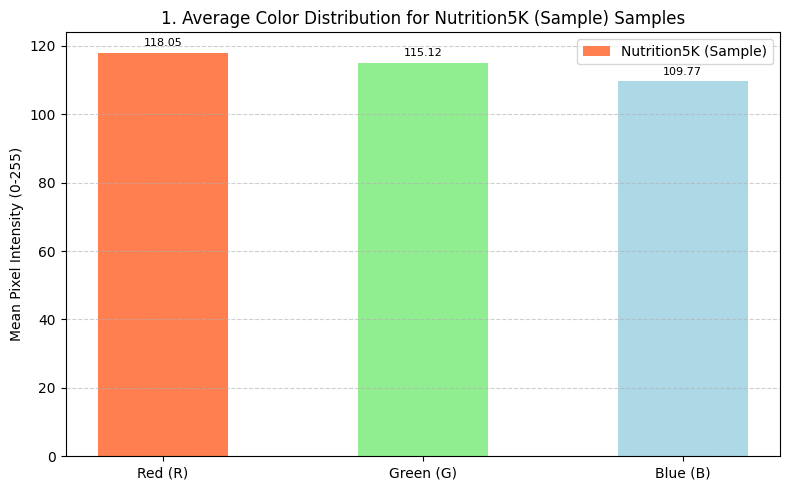

Displaying Texture Distribution bar chart (Plot 2)...


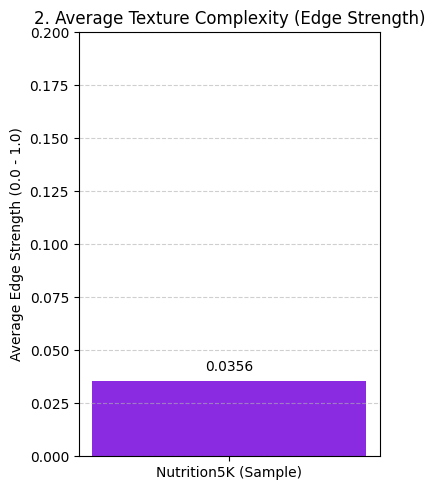

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.io import imread # Used for loading image files
from skimage.transform import resize
from skimage.filters import sobel # Used for calculating image gradients (texture)

# --- Configuration ---
# 1. Nutrition5K Sample Dataset (The only dataset being analyzed)
N5K_SAMPLE_DIR = './rgb_samples_fixed/' # Directory where your N5K sample images were downloaded
N5K_NAME = 'Nutrition5K (Sample)'
TARGET_SIZE = (224, 224, 3) # Standard size for image analysis

# --- 1. Data Loading Function ---

def load_local_nutrition5k_samples():
    """Loads local N5K sample images from the fixed directory."""
    images = []

    # Check if the directory exists
    if not os.path.exists(N5K_SAMPLE_DIR):
        print(f"Error: N5K sample directory not found at {N5K_SAMPLE_DIR}")
        return np.array([])

    print(f"Loading images from {N5K_SAMPLE_DIR}...")

    # Iterate through all files in the directory
    for filename in os.listdir(N5K_SAMPLE_DIR):
        if filename.endswith(".png"): # Assuming the samples are .png
            filepath = os.path.join(N5K_SAMPLE_DIR, filename)
            try:
                # Load image (skimage.io.imread handles different formats and returns np array)
                img = imread(filepath)
                # Resize the image to match a standard size (essential for analysis)
                img_resized = resize(img, TARGET_SIZE, anti_aliasing=True, preserve_range=True)

                # Ensure the image has 3 color channels (e.g., handles 4-channel PNGs or grayscale conversion)
                if img_resized.ndim == 3 and img_resized.shape[-1] == 4: # Handle PNGs with alpha channel
                     img_resized = img_resized[:, :, :3]
                elif img_resized.ndim == 2: # Handle grayscale images (1 channel)
                    # Stack the single channel 3 times to create an RGB image
                    img_resized = np.stack([img_resized, img_resized, img_resized], axis=-1)

                # Ensure the final output is uint8 (0-255 range)
                images.append(img_resized.astype(np.uint8))
            except Exception as e:
                print(f"Could not load or process image {filename}: {e}")

    return np.array(images)


# --- 2. Analysis Functions ---

def calculate_mean_rgb(image_array):
    """Calculates the average R, G, and B values across the entire dataset."""
    if image_array.size == 0:
        return {'R': 0, 'G': 0, 'B': 0}

    # Normalize pixel values to 0-1 range for accurate averaging
    image_array = image_array.astype(np.float32) / 255.0

    # Calculate the mean across all dimensions except the channel dimension (axis 3)
    mean_rgb = np.mean(image_array, axis=(0, 1, 2))

    # Convert back to the 0-255 range for easier interpretation
    return {
        'R': mean_rgb[0] * 255,
        'G': mean_rgb[1] * 255,
        'B': mean_rgb[2] * 255
    }

def calculate_mean_texture(image_array):
    """
    Calculates the average texture strength (edge magnitude) using the Sobel operator.
    Higher values indicate more sharp, complex, or varied textures.
    """
    if image_array.size == 0:
        return 0.0

    # Convert array to grayscale first, as Sobel is most reliably applied to a single channel
    grayscale_array = np.mean(image_array, axis=3) / 255.0 # Normalize to 0-1 float range

    texture_magnitudes = []

    # Iterate over each image in the dataset
    for img_gray in grayscale_array:
        # Calculate the magnitude of the image gradient (edge strength)
        edges = sobel(img_gray)
        texture_magnitudes.append(np.mean(edges))

    # Return the mean texture strength across all images
    return np.mean(texture_magnitudes)


# --- 3. Visualization Functions (Separated) ---

def visualize_color_distribution(n5k_rgb):
    """Generates a bar chart showing the mean RGB values for the N5K dataset."""

    channels = ['Red (R)', 'Green (G)', 'Blue (B)']
    n5k_values = [n5k_rgb['R'], n5k_rgb['G'], n5k_rgb['B']]
    x = np.arange(len(channels))
    width = 0.5

    fig, ax = plt.subplots(figsize=(8, 5))
    rects = ax.bar(x, n5k_values, width, label=N5K_NAME, color=['#FF7F50', '#90EE90', '#ADD8E6'])

    ax.set_ylabel('Mean Pixel Intensity (0-255)')
    ax.set_title(f'1. Average Color Distribution for {N5K_NAME} Samples')
    ax.set_xticks(x)
    ax.set_xticklabels(channels)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=8)

    autolabel(rects)

    fig.tight_layout()
    plt.show()

def visualize_texture_distribution(n5k_texture):
    """Generates a bar chart showing the mean texture magnitude for the N5K dataset."""

    fig, ax = plt.subplots(figsize=(4, 5))
    bar = ax.bar([N5K_NAME], [n5k_texture], color='#8A2BE2')

    ax.set_ylabel('Average Edge Strength (0.0 - 1.0)')
    ax.set_title('2. Average Texture Complexity (Edge Strength)')
    ax.set_ylim(0, 0.2)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    for rect in bar:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)

    fig.tight_layout()
    plt.show()


# --- Main Execution ---

print("--- Starting Nutrition5K Visual Composition Analysis ---")

# 1. Load Nutrition5k Sample Data
n5k_samples = load_local_nutrition5k_samples()
if n5k_samples.size == 0:
    print("Cannot proceed with N5K sample data. Check your sample folder.")
    exit()

print(f"N5K Samples Loaded: {n5k_samples.shape[0]} images.")

# 2. Calculate Mean RGB (Color)
n5k_mean_rgb = calculate_mean_rgb(n5k_samples)
print("\n--- Calculated Mean RGB Values (0-255) ---")
print(f"Color Signature: R={n5k_mean_rgb['R']:.2f}, G={n5k_mean_rgb['G']:.2f}, B={n5k_mean_rgb['B']:.2f}")

# 3. Calculate Mean Texture (Edge Strength)
n5k_mean_texture = calculate_mean_texture(n5k_samples)
print("\n--- Calculated Mean Texture Value (Edge Strength) ---")
print(f"Texture Signature (0-1): {n5k_mean_texture:.4f}")


# 4. Visualize Results (Separated Plots)
print("\nDisplaying Color Distribution bar chart (Plot 1)...")
visualize_color_distribution(n5k_mean_rgb)

print("Displaying Texture Distribution bar chart (Plot 2)...")
visualize_texture_distribution(n5k_mean_texture)


--- Starting Nutrition5K Visual Composition Analysis ---
Loading images from ./rgb_samples_fixed/...
N5K Samples Loaded: 50 images.
Calculated per-image metrics for R, G, B, Texture, and CoM.

--- Summary of Dataset Averages ---
Mean R/G/B Signature: R=118.05, G=115.04, B=109.70
Mean Texture (0-1): 0.0356
Mean CoM (X/Y): X=0.49, Y=0.50

Displaying Distribution Plots (Histograms/Bell Curve)...


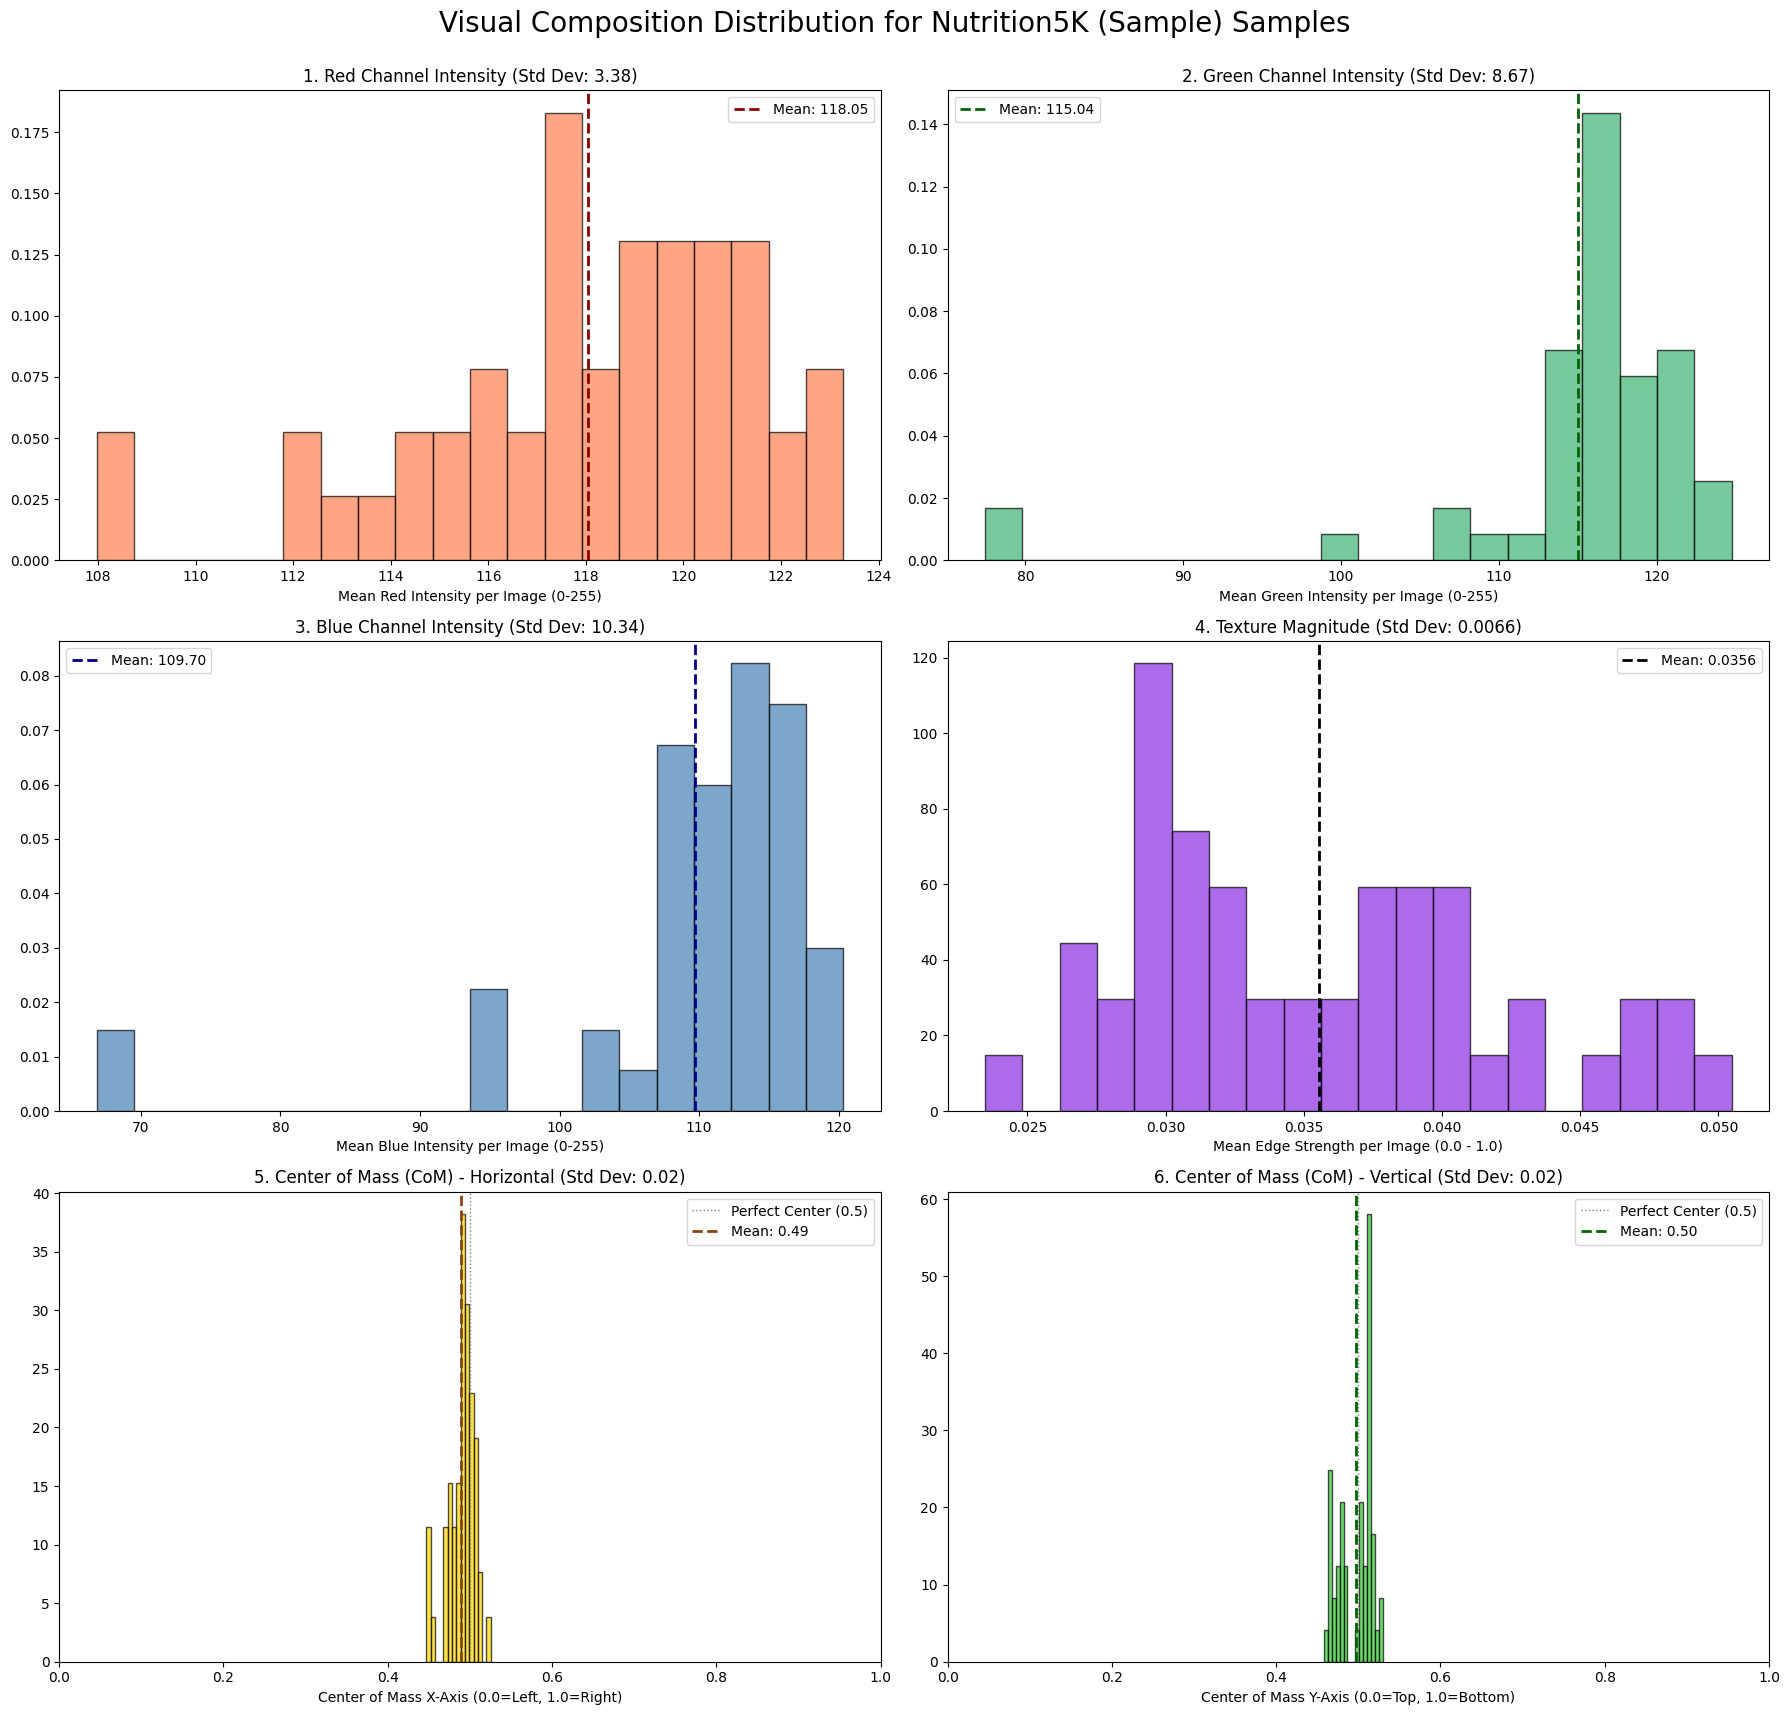

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.io import imread # Used for loading image files
from skimage.transform import resize
from skimage.filters import sobel # Used for calculating image gradients (texture)
from scipy.ndimage import center_of_mass # Used for calculating spatial center

# --- Configuration ---
# 1. Nutrition5K Sample Dataset (The only dataset being analyzed)
N5K_SAMPLE_DIR = './rgb_samples_fixed/' # Directory where your N5K sample images were downloaded
N5K_NAME = 'Nutrition5K (Sample)'
TARGET_SIZE = (224, 224, 3) # Standard size for image analysis (H, W, C)

# --- 1. Data Loading Function ---

def load_local_nutrition5k_samples():
    """Loads local N5K sample images from the fixed directory."""
    images = []

    # Check if the directory exists
    if not os.path.exists(N5K_SAMPLE_DIR):
        print(f"Error: N5K sample directory not found at {N5K_SAMPLE_DIR}")
        return np.array([])

    print(f"Loading images from {N5K_SAMPLE_DIR}...")

    # Iterate through all files in the directory
    for filename in os.listdir(N5K_SAMPLE_DIR):
        if filename.endswith(".png"): # Assuming the samples are .png
            filepath = os.path.join(N5K_SAMPLE_DIR, filename)
            try:
                # Load image (skimage.io.imread handles different formats and returns np array)
                img = imread(filepath)
                # Resize the image to match a standard size (essential for analysis)
                img_resized = resize(img, TARGET_SIZE, anti_aliasing=True, preserve_range=True)

                # Ensure the image has 3 color channels (e.g., handles 4-channel PNGs or grayscale conversion)
                if img_resized.ndim == 3 and img_resized.shape[-1] == 4: # Handle PNGs with alpha channel
                     img_resized = img_resized[:, :, :3]
                elif img_resized.ndim == 2: # Handle grayscale images (1 channel)
                    # Stack the single channel 3 times to create an RGB image
                    img_resized = np.stack([img_resized, img_resized, img_resized], axis=-1)

                # Ensure the final output is uint8 (0-255 range)
                images.append(img_resized.astype(np.uint8))
            except Exception as e:
                print(f"Could not load or process image {filename}: {e}")

    return np.array(images)


# --- 2. Analysis Functions ---

def calculate_mean_texture(image_array):
    """Calculates the average texture magnitude across the entire dataset (for summary)."""
    if image_array.size == 0:
        return 0.0

    # Normalize pixel values to 0-1 range
    image_array = image_array.astype(np.float32) / 255.0

    # Calculate Sobel edges for all images in the array
    texture_mags = []
    for img in image_array:
        img_gray = np.mean(img, axis=2) # Convert to grayscale
        edges = sobel(img_gray) # Calculate edge magnitude
        texture_mags.append(np.mean(edges)) # Store average edge strength

    return np.mean(texture_mags)


def calculate_all_per_image_metrics(image_array):
    """
    Calculates the mean R, G, B, Texture, and Center of Mass for *each individual image*
    to build the distribution plot data.
    """
    if image_array.size == 0:
        return {'R': [], 'G': [], 'B': [], 'Texture': [], 'CoM_X': [], 'CoM_Y': []}

    N = image_array.shape[0]
    R, G, B, Texture, CoM_X, CoM_Y = [], [], [], [], [], []

    # Iterate over each image
    for i in range(N):
        # Normalize to 0-1 float range
        img = image_array[i].astype(np.float32) / 255.0

        # 1. COLOR (R, G, B)
        mean_rgb = np.mean(img, axis=(0, 1)) * 255
        R.append(mean_rgb[0])
        G.append(mean_rgb[1])
        B.append(mean_rgb[2])

        # 2. TEXTURE (Edge Strength)
        img_gray = np.mean(img, axis=2) # Convert to grayscale
        edges = sobel(img_gray) # Calculate edge magnitude
        Texture.append(np.mean(edges)) # Store average edge strength

        # 3. SPATIAL ARRANGEMENT (Center of Mass - CoM)
        # We use the grayscale image (intensity) as the "mass" map
        # CoM returns (Y_index, X_index)
        com_y, com_x = center_of_mass(img_gray)

        # Normalize CoM coordinates to range from 0.0 (left/top) to 1.0 (right/bottom)
        normalized_com_x = com_x / img.shape[1]
        normalized_com_y = com_y / img.shape[0]

        CoM_X.append(normalized_com_x)
        CoM_Y.append(normalized_com_y)

    return {'R': R, 'G': G, 'B': B, 'Texture': Texture, 'CoM_X': CoM_X, 'CoM_Y': CoM_Y}


# --- 3. Visualization Function (Distribution Plots) ---

def visualize_distribution_plots(metrics_data):
    """Generates histograms showing the distribution of all 5 visual features."""

    # Data extraction
    R_data = metrics_data['R']
    G_data = metrics_data['G']
    B_data = metrics_data['B']
    Texture_data = metrics_data['Texture']
    CoM_X_data = metrics_data['CoM_X']
    CoM_Y_data = metrics_data['CoM_Y']

    # 3 rows and 2 columns for six separate plots
    fig, axes = plt.subplots(3, 2, figsize=(18, 18))
    fig.suptitle(f'Visual Composition Distribution for {N5K_NAME} Samples', fontsize=20)

    # Flatten the axes array for easier indexing: ax[0] to ax[5]
    ax = axes.flatten()

    # --- Plot 1: Red Channel Distribution (Color Warmth) ---
    ax[0].hist(R_data, bins=20, density=True, color='#FF7F50', alpha=0.7, edgecolor='black')
    mean_r = np.mean(R_data); std_r = np.std(R_data)
    ax[0].axvline(mean_r, color='darkred', linestyle='dashed', linewidth=2, label=f'Mean: {mean_r:.2f}')
    ax[0].set_xlabel('Mean Red Intensity per Image (0-255)')
    ax[0].set_title(f'1. Red Channel Intensity (Std Dev: {std_r:.2f})')
    ax[0].legend()

    # --- Plot 2: Green Channel Distribution (Freshness/Saturation) ---
    ax[1].hist(G_data, bins=20, density=True, color='#3CB371', alpha=0.7, edgecolor='black')
    mean_g = np.mean(G_data); std_g = np.std(G_data)
    ax[1].axvline(mean_g, color='darkgreen', linestyle='dashed', linewidth=2, label=f'Mean: {mean_g:.2f}')
    ax[1].set_xlabel('Mean Green Intensity per Image (0-255)')
    ax[1].set_title(f'2. Green Channel Intensity (Std Dev: {std_g:.2f})')
    ax[1].legend()

    # --- Plot 3: Blue Channel Distribution (Coolness/Background) ---
    ax[2].hist(B_data, bins=20, density=True, color='#4682B4', alpha=0.7, edgecolor='black')
    mean_b = np.mean(B_data); std_b = np.std(B_data)
    ax[2].axvline(mean_b, color='darkblue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_b:.2f}')
    ax[2].set_xlabel('Mean Blue Intensity per Image (0-255)')
    ax[2].set_title(f'3. Blue Channel Intensity (Std Dev: {std_b:.2f})')
    ax[2].legend()

    # --- Plot 4: Texture Distribution (Complexity) ---
    ax[3].hist(Texture_data, bins=20, density=True, color='#8A2BE2', alpha=0.7, edgecolor='black')
    mean_t = np.mean(Texture_data); std_t = np.std(Texture_data)
    ax[3].axvline(mean_t, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean_t:.4f}')
    ax[3].set_xlabel('Mean Edge Strength per Image (0.0 - 1.0)')
    ax[3].set_title(f'4. Texture Magnitude (Std Dev: {std_t:.4f})')
    ax[3].legend()

    # --- Plot 5: Spatial Arrangement - CoM X (Horizontal Plating) ---
    ax[4].hist(CoM_X_data, bins=15, density=True, color='#FFD700', alpha=0.7, edgecolor='black')
    mean_x = np.mean(CoM_X_data); std_x = np.std(CoM_X_data)
    ax[4].axvline(0.5, color='gray', linestyle='dotted', linewidth=1, label='Perfect Center (0.5)')
    ax[4].axvline(mean_x, color='saddlebrown', linestyle='dashed', linewidth=2, label=f'Mean: {mean_x:.2f}')
    ax[4].set_xlabel('Center of Mass X-Axis (0.0=Left, 1.0=Right)')
    ax[4].set_title(f'5. Center of Mass (CoM) - Horizontal (Std Dev: {std_x:.2f})')
    ax[4].legend()
    ax[4].set_xlim(0.0, 1.0) # Ensure scale is 0 to 1 for normalized coords

    # --- Plot 6: Spatial Arrangement - CoM Y (Vertical Plating) ---
    ax[5].hist(CoM_Y_data, bins=15, density=True, color='#32CD32', alpha=0.7, edgecolor='black')
    mean_y = np.mean(CoM_Y_data); std_y = np.std(CoM_Y_data)
    ax[5].axvline(0.5, color='gray', linestyle='dotted', linewidth=1, label='Perfect Center (0.5)')
    ax[5].axvline(mean_y, color='darkgreen', linestyle='dashed', linewidth=2, label=f'Mean: {mean_y:.2f}')
    ax[5].set_xlabel('Center of Mass Y-Axis (0.0=Top, 1.0=Bottom)')
    ax[5].set_title(f'6. Center of Mass (CoM) - Vertical (Std Dev: {std_y:.2f})')
    ax[5].legend()
    ax[5].set_xlim(0.0, 1.0) # Ensure scale is 0 to 1 for normalized coords

    fig.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout
    plt.show()


# --- Main Execution ---

print("--- Starting Nutrition5K Visual Composition Analysis ---")

# 1. Load Nutrition5k Sample Data
n5k_samples = load_local_nutrition5k_samples()
if n5k_samples.size == 0:
    print("Cannot proceed with N5K sample data. Check your sample folder.")
    exit()

print(f"N5K Samples Loaded: {n5k_samples.shape[0]} images.")

# 2. Calculate ALL Per-Image Metrics for Distribution Plots
all_metrics = calculate_all_per_image_metrics(n5k_samples)
print("Calculated per-image metrics for R, G, B, Texture, and CoM.")

# 3. Calculate Mean Texture (for simple summary)
n5k_mean_texture_summary = calculate_mean_texture(n5k_samples)

print("\n--- Summary of Dataset Averages ---")
# Calculate mean RGB for quick print
mean_r_summary = np.mean(all_metrics['R'])
mean_g_summary = np.mean(all_metrics['G'])
mean_b_summary = np.mean(all_metrics['B'])

print(f"Mean R/G/B Signature: R={mean_r_summary:.2f}, G={mean_g_summary:.2f}, B={mean_b_summary:.2f}")
print(f"Mean Texture (0-1): {n5k_mean_texture_summary:.4f}")
print(f"Mean CoM (X/Y): X={np.mean(all_metrics['CoM_X']):.2f}, Y={np.mean(all_metrics['CoM_Y']):.2f}")


# 4. Visualize Distribution
print("\nDisplaying Distribution Plots (Histograms/Bell Curve)...")
visualize_distribution_plots(all_metrics)